In [1]:
%run ../initlibs.py cryptomomentum dark

from models.research_utils import prepare_data, load_simulation_data, collect_entries_data, fast_backtest
from models.turtless_model import TurtlesGenerator, RollingHiLo, PivotsBreaks
setup_mpl_theme('dark') # run this if need to switch to light charts theme

import ira
%alphalab dark
from alpha.utils.stat_helpers import signals_statistics

from models.market_regime import MarketRegime

Reloaded /usr/local/envs/ira_p36/lib/python3.6/site-packages/ira/experimental/c_simulator_core.pyx


Planned research

1. Check different market regimes indicators as best for existing models
    1. ADX
    2. AutoCorrelation
    3. Volatility and Volatility adjusted momentum
    4. MACI
    
We need to test IBS and turtles signals for best filter


# Simulations results

In [20]:
sim1 = load_simulation_data('Turtles1@TurtlesStrategy')

Statistic,Model
Gain (USD):,1417.86
CAGR (%):,34.911
Sharpe:,0.885
Sortino:,3.881
Calmar:,2.023
MaxDD (%):,33.535
MaxDD On Init BP (%):,78.146
MaxDD (USD):,781.461
MaxDD days:,205 days
MaxDD start:,2019-04-03

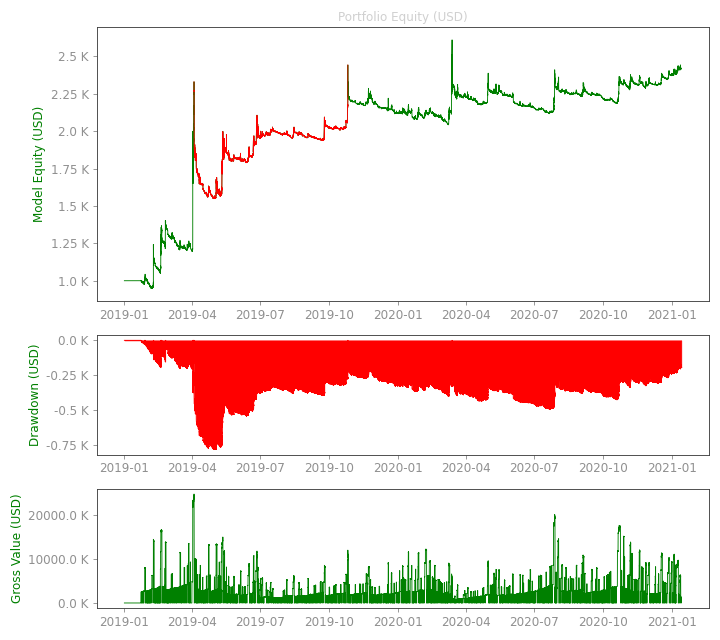

<Figure size 720x640 with 0 Axes>

In [21]:
tearsheet(sim1.portfolio, 1000)

In [22]:
s1_ent = collect_entries_data(sim1)
s1_xbt = s1_ent[s1_ent.Instrument=='BITMEX:XBTUSD']
# s1_xbt = s1_ent[s1_ent.Instrument=='BITMEX:ETHUSD']

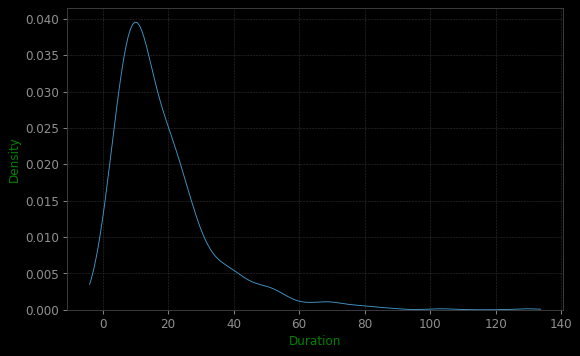

In [23]:
sns.kdeplot(s1_xbt.Duration.astype(int)/(1000000000*3600), cut=1)

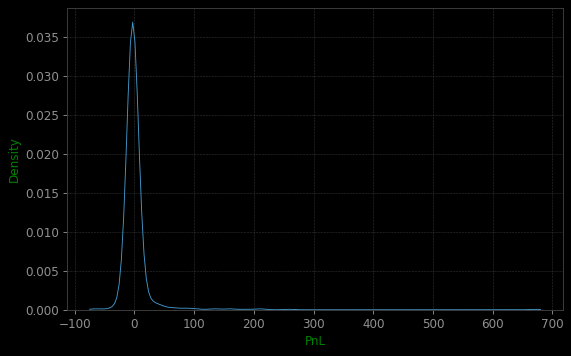

In [24]:
sns.kdeplot(s1_xbt.PnL, cut=1)
# plt.xlim(-100, 200)

In [25]:
pfactor = sum(s1_xbt.PnL[s1_ent.PnL>0]) / sum(-s1_xbt.PnL[s1_ent.PnL<0])
pfactor

1.533614773822294

# Introducing market regimes

In [2]:
dx = prepare_data('BTCUSDT', timeframes=['5Min', '15Min', '1H', '4H', '6H', '12H', '1D'])
# dx = prepare_data('ETHUSDT', timeframes=['5Min', '15Min', '1H', '4H', '6H', '12H', '1D'])

In [3]:
class ADXRegime(MarketRegime):
    """
    Classical ADX regime detector
      1: trend regime (adx > T)
      0: flat regime
    """
    def calculate(self, data, prevent_shift):
        # adx uses H/L so we should shift it
        ind = adx(data, self.period, sma, as_frame=True).shift(1)
        r = pd.Series(0, index=ind.index)
        r[ind.ADX > self.threshold] = 1
        return r
    
class AcorrRegime(MarketRegime):
    """
    Regime based returns series autocorrelation 
      -1: mean reversion regime (negative correlation < t_mr)
       0: uncertain (t_mr < corr < r_mo)
      +1: momentum regime (positive correlation > t_mo)
    """
    def calculate(self, data, prevent_shift):
        sft_num = 0 if self._column != 'close' or prevent_shift else 1
        returns = data[self._column].pct_change()
        ind = rolling_autocorrelation(returns, self.lag, self.period).shift(sft_num)
        r = pd.Series(0, index=ind.index)
        r[ind <= self.t_mr] = -1
        r[ind >= self.t_mo] = +1
        return r
    
class VolatilityRegime(MarketRegime):
    """
    Regime based on volatility
       0: flat
      +1: volatile market 
    """
    def calculate(self, data, prevent_shift):
        inst_vol = atr(data, self.instant_period)
        typical_vol = atr(data, self.typical_period)
        r = pd.Series(0, index=data.index)
        r[inst_vol > typical_vol * self.factor] = +1
        return r

In [26]:
m1 = ADXRegime(period=3*12, threshold=5).fit(dx.H4)
m2 = AcorrRegime(period=3*12, lag=1, t_mr=-0.1, t_mo=0.1).fit(dx.H4)
m3 = VolatilityRegime(instant_period=3*12, typical_period=12*24, factor=1).fit(dx.M5)

# sns.kdeplot(m1.regime())
# sns.kdeplot(m2.regime())

# mrs = scols(s1_xbt, (s1_xbt.PnL > 0).rename('Success'), m2.regime(s1_xbt), m1.regime(s1_xbt)).dropna()
# mrs.groupby(['ADXRegime', 'AcorrRegime', 'Success']).PnL.sum()
# mrs

In [27]:
m1 = ADXRegime(period=36, threshold=15).fit(dx.M15)
# m1 = ADXRegime(period=12, threshold=15).fit(dx.H1)
m2 = AcorrRegime(period=3*12, lag=1, t_mr=-0.01, t_mo=0.01).fit(dx.M5)
# m3 = VolatilityRegime(instant_period=12, typical_period=12*24, factor=1).fit(dx.H1)
m3 = VolatilityRegime(instant_period=6, typical_period=24, factor=1).fit(dx.H1)

mrs = scols(s1_xbt, (s1_xbt.PnL > 0).rename('Success'), 
            m3.regime(s1_xbt), 
            m2.regime(s1_xbt), 
            m1.regime(s1_xbt),
           ).dropna()

max_pf, best_selector, best_regime = 0, None, None
for regime_selector in ['AcorrRegime', 'ADXRegime', 'VolatilityRegime']:
    o1 = mrs.groupby([regime_selector, 'Success']).PnL.sum()
    for r in set(mrs[regime_selector]):
        losses, profits = -o1[(r, False)], o1[(r, True)]
        pf = profits / losses
        print(f'{green(regime_selector)} [{int(r):2d}] : {pf:.3f} | Sum profit/loss: ${profits:.2f} / ${losses: .2f} -> ${profits - losses: .2f}')
        if pf > max_pf:
            max_pf, best_selector, best_regime = pf, regime_selector, r            
            
print(f'Best PF: {max_pf:.2f}, when regime selector {red(best_selector)} in {best_regime} ') 

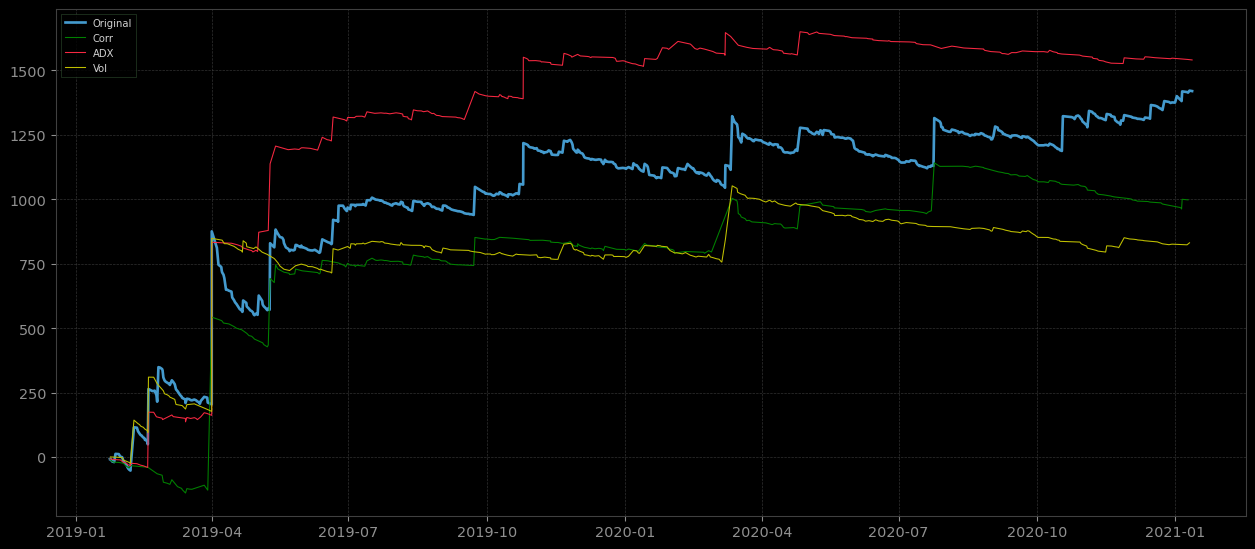

In [28]:
fig(16, 7)
plt.plot(mrs.PnL.cumsum(), label='Original', lw=2)
plt.plot(mrs[mrs.AcorrRegime==1].PnL.cumsum(), label='Corr')
plt.plot(mrs[mrs.ADXRegime==0].PnL.cumsum(), label='ADX')
plt.plot(mrs[mrs.VolatilityRegime==1].PnL.cumsum(), label='Vol'); plt.legend();

Applying filters
<hr/>

In [41]:
rhi_enter, rhi_exit = RollingHiLo(dx.H1, 10), RollingHiLo(dx.H1, 10)
t_roll_best1 = TurtlesGenerator(rhi_enter, rhi_exit, account_size=5000, dollar_per_point=1, after_lose_only=False, atr_period='1H')
s_roll_best1 = t_roll_best1.get_signals(dx.M5['2019-01':])
pf_test_all = fast_backtest(dx.instrument, s_roll_best1, dx.M5)

2021-01-13 12:05:42,751 - ira.simulator.SignalTester - WARNING - Positions at [2019-01-01 23:24:59] will be skipped: no prices found


In [30]:
mr_f1 = AcorrRegime(period=3*12, lag=1, t_mr=-0.01, t_mo=0.01).fit(dx.M5)
fr1 = mr_f1.regime(s_roll_best1)
s_roll_best_rf1 = s_roll_best1.loc[fr1[fr1.AcorrRegime==1].index]
pf_test_f1 = fast_backtest(dx.instrument, s_roll_best_rf1, dx.M5)

2021-01-13 11:19:02,061 - ira.simulator.SignalTester - WARNING - Positions at [2019-01-01 23:24:59] will be skipped: no prices found


In [31]:
mr_f2 = ADXRegime(period=36, threshold=15).fit(dx.M5)
fr2 = mr_f2.regime(s_roll_best1)
s_roll_best_rf2 = s_roll_best1.loc[fr2[fr2.ADXRegime==0].index]
pf_test_f2 = fast_backtest(dx.instrument, s_roll_best_rf2, dx.M5)

2021-01-13 11:19:21,017 - ira.simulator.SignalTester - WARNING - Positions at [2019-01-02 21:44:59] will be skipped: no prices found


In [32]:
mr_f3 = VolatilityRegime(instant_period=3*12, typical_period=12*24, factor=1).fit(dx.M5)
fr3 = mr_f3.regime(s_roll_best1)
s_roll_best_rf3 = s_roll_best1.loc[fr3[fr3.VolatilityRegime==1].index]
pf_test_f3 = fast_backtest(dx.instrument, s_roll_best_rf3, dx.M5)

2021-01-13 11:19:40,045 - ira.simulator.SignalTester - WARNING - Positions at [2019-01-01 23:24:59] will be skipped: no prices found


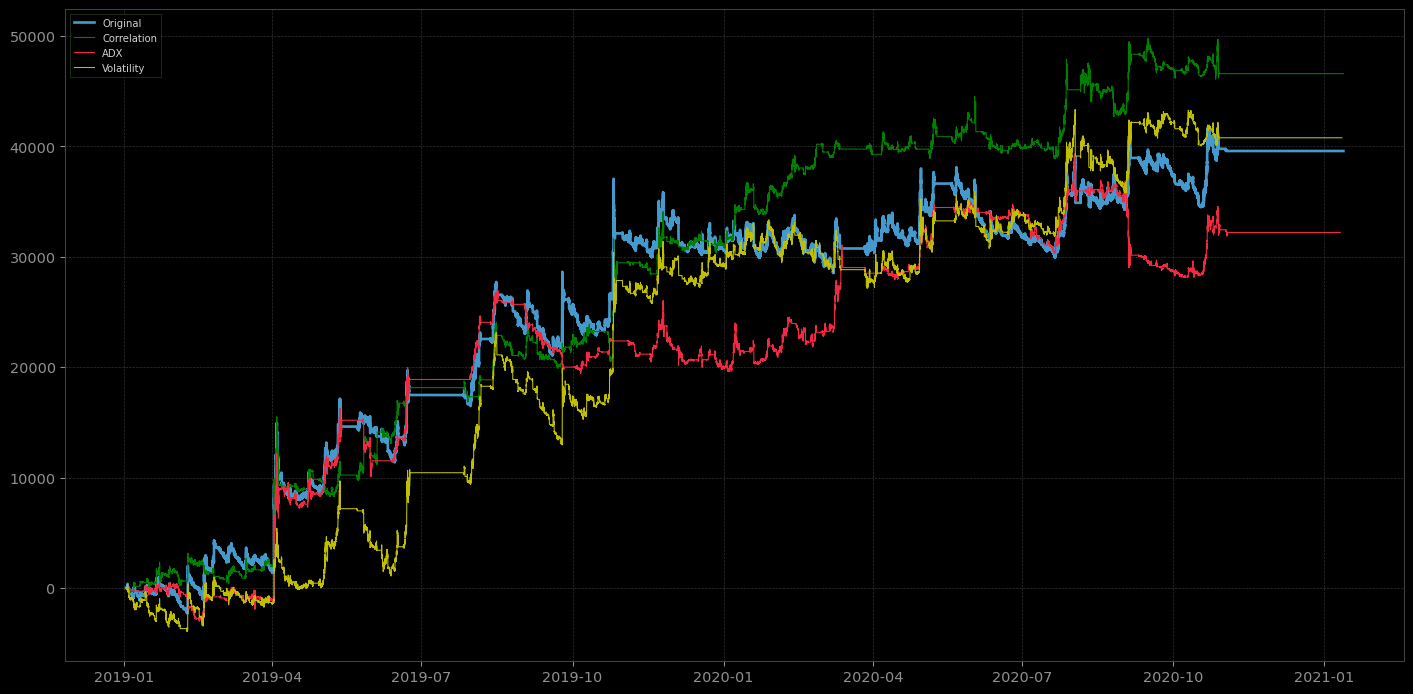

In [36]:
fig(18, 9)
# plt.plot(r.portfolio.filter(regex='.*_PnL').cumsum()*14)
plt.plot(pf_test_all.filter(regex='.*_PnL').cumsum(), lw=2, label='Original')
plt.plot(pf_test_f1.filter(regex='.*_PnL').cumsum(), label='Correlation')
plt.plot(pf_test_f2.filter(regex='.*_PnL').cumsum(), label='ADX')
plt.plot(pf_test_f3.filter(regex='.*_PnL').cumsum(), label='Volatility'); plt.legend();

Statistic,Model
Gain (USD):,39583.03
CAGR (%):,110.027
Sharpe:,1.018
Sortino:,4.459
Calmar:,2.303
MaxDD (%):,20.287
MaxDD On Init BP (%):,170.663
MaxDD (USD):,8533.130
MaxDD days:,187 days
MaxDD start:,2019-10-26

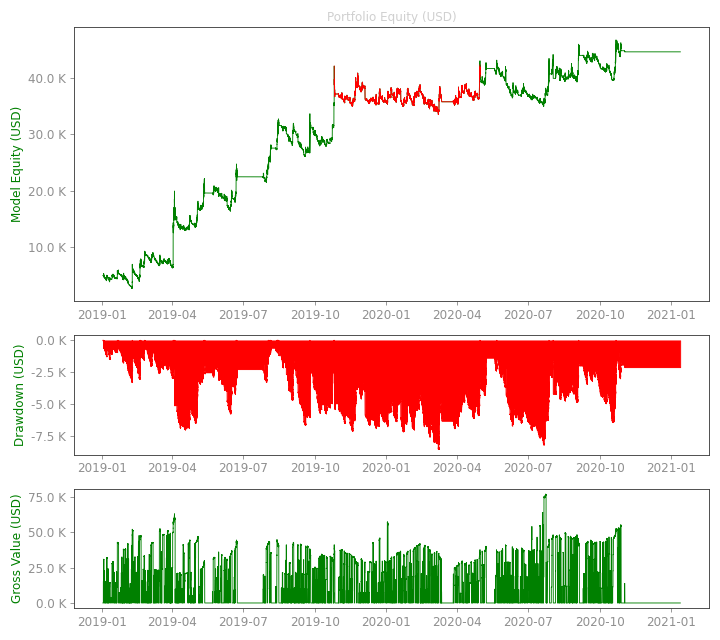
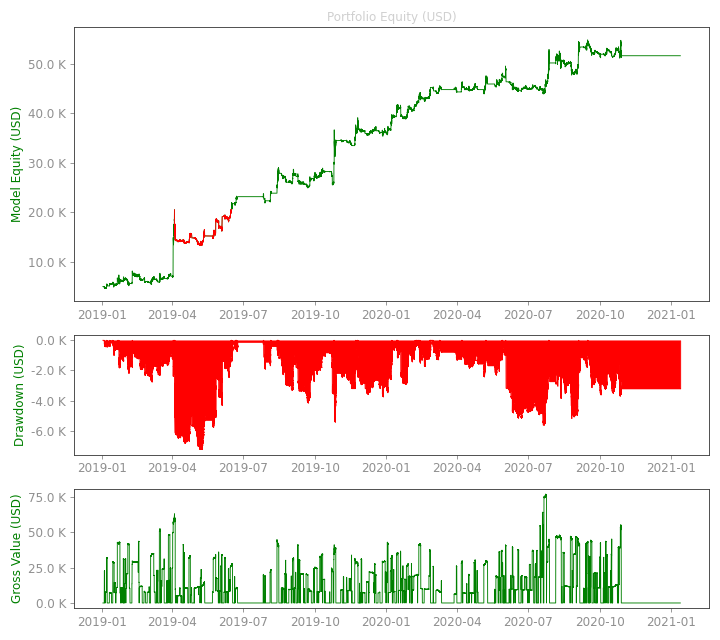

<Figure size 720x640 with 0 Axes>

<Figure size 720x640 with 0 Axes>

In [34]:
tearsheets(pf_test_all, pf_test_f1, init_cash=5000)

In [349]:
# tearsheets(pf_test_all, pf_test_f1, pf_test_f2, pf_test_f3, init_cash=5000)

In [ ]:
plt.plot(d.ask)